In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import plotting_fxns as plotfxns

This notebook is intended to make plotting of the PyGEM-EB output straightforward for fast diagnostics after a model run. Most functions just need the information for the model run in the cell below. 

In [2]:
# Filepath to the model run output
file = '/home/claire/research/Output/EB/run_2023_09_12_hourly_2.nc'

Specify the plotting style to use and the figure name to save the plot.

In [3]:
# Define additional plotting variables
style.use('seaborn')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
figname = 'Figure'+today+'.png'

Run the following cells to plot the data. For information on any of the plotting functions, run 'help(name_of_function)'. Available functions are:
- plot_avgs
- plot_yrs
- plot_avg_layers
- plot_layers_monthly

In [4]:
# Load in the data and define the number of years in the model run
ds = xr.open_dataset(file)
startdate = pd.to_datetime(ds.indexes['time'].to_numpy()[0])
enddate = pd.to_datetime(ds.indexes['time'].to_numpy()[-1])
nyr = enddate.year-startdate.year 

In [ ]:
MB_vars = ['melt','runoff','accum','refreeze'] # ,'snowdepth'
EB_vars = ['surftemp','SWnet','LWnet','rain','sensible','latent','meltenergy']
temp_vars = ['airtemp','surftemp']

In [65]:
file = '/home/claire/research/Output/EB/run_2023_09_13_hourly_scratch.nc'
# 9-12 11 is a decent one
ds = xr.open_dataset(file)
ds['SWnet'] = ds['SWin'] + ds['SWout']
ds['LWnet'] = ds['LWin'] + ds['LWout']
ds['NetRad'] = ds['SWnet'] + ds['LWnet']
ds['albedo'] = -ds['SWout'] / ds['SWin']
ds['sum'] = ds['SWnet'] + ds['LWnet'] + ds['rain'] + ds['sensible'] + ds['latent']

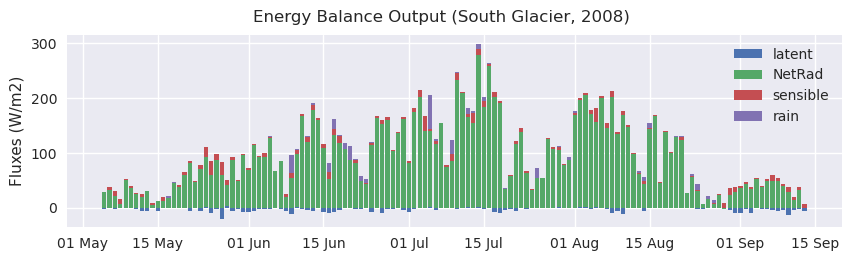

In [66]:
# 'layertemp','layerdensity','layerwater','layerheight'
plotfxns.stacked_eb_barplot(ds,[startdate,enddate],colors,'d')
# plotfxns.simple_plot(ds,[startdate,enddate],['snowdepth','LWin','LWout'],colors,'h')

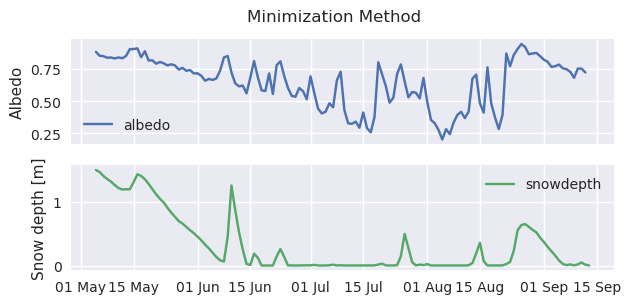

In [68]:
plotfxns.simple_plot(ds,[startdate,enddate],[['albedo'],['snowdepth']],colors,res='d')

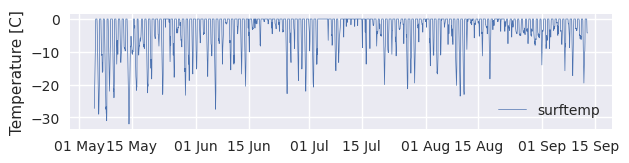

In [44]:
plotfxns.simple_plot(ds,[startdate,enddate],['surftemp'],colors,res='h')

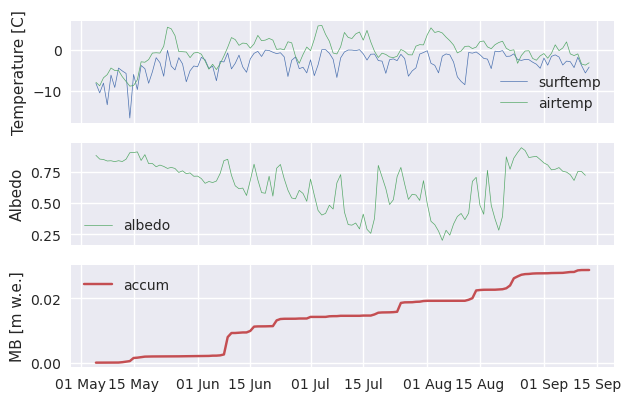

In [52]:
plotfxns.simple_plot(ds,[startdate,enddate],[['surftemp','airtemp'],['albedo'],['accum']],colors,res='d')

In [20]:
months_to_plot = np.int64(np.linspace(0,11,5))
# plotfxns.plot_layers_monthly(file,'layertemp',months_to_plot,colors)
# plotfxns.plot_avgs(file,nyr,title='South Glacier')

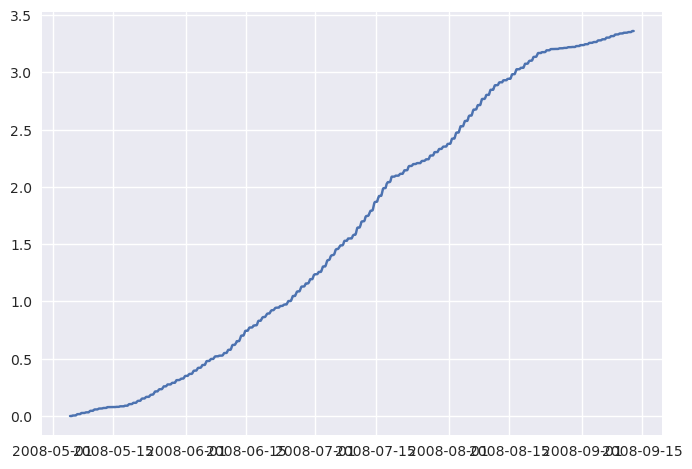

In [53]:
plt.plot(ds.coords['time'],np.cumsum(ds.melt))
plt.show()

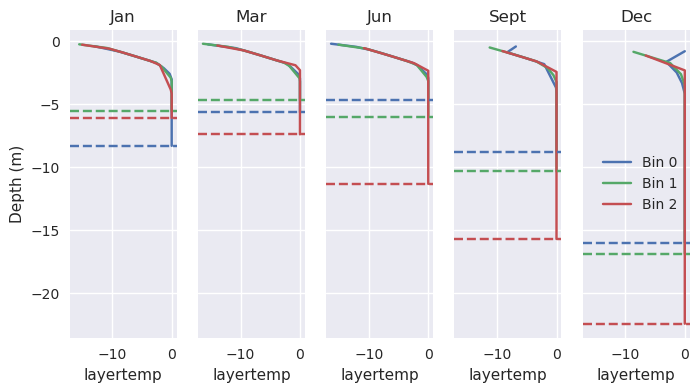

In [ ]:
plotfxns.plot_layers_monthly(file,'layertemp',months_to_plot,colors)

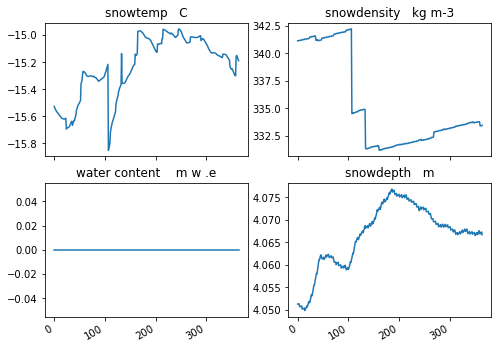

In [ ]:
plot_avg_layers(file,bin,nyr)

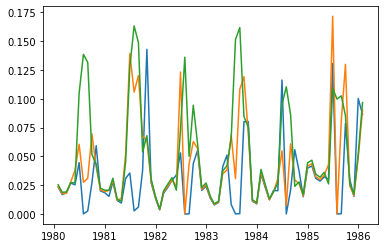

In [ ]:
ds = xr.open_dataset(file)
accum = ds['accum'].to_pandas()
accum = accum.resample('M').mean()*1000
plt.plot(accum.index,accum)
plt.show()

In [ ]:
import xarray as xr
ds = xr.open_dataset('/home/claire/research/climate_data/ERA5/ERA5_hourly/ERA5_precip_hourly.nc')
print(np.mean(ds['tp'].values),np.max(ds['tp'].values))
print(np.sum(ds['tp'].values[:8790]))

9.609282174515584e-05 0.004886787384748459


In [ ]:
# def plot_diurnal(file,bin):
ds = xr.open_dataset(file)
fig,axes = plt.subplots(2,2,sharey=True,sharex=True,figsize=(8,4)) #,sharex=True,sharey='row'
df = ds['snowdepth'].to_pandas()